In [1]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import seaborn as sn
from tqdm import tqdm
from Model_Wrapper import Wrapper
import matplotlib.pyplot as plt
import torch.nn.functional as F
from Datasets import dataset 
import os 
from torch.utils.tensorboard import SummaryWriter 
import shutil

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
def set_random_seed(random_seed=None):
    if random_seed is None:
        random_seed = 13
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to: {random_seed}")

In [4]:
set_random_seed()

Random seed set to: 13


In [5]:
transform = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
train_ds =dataset(root = "images/",transform=transform, split = "train")
test_ds =dataset(root = "images/",transform=transform, split = "test")
classes = ("Robots", "Humans")
print(f"train size :{train_ds.__len__()} \n test size :{test_ds.__len__()} ")

train size :339 
 test size :146 


In [7]:
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False)
class_names = ["Humans", "Robots"]

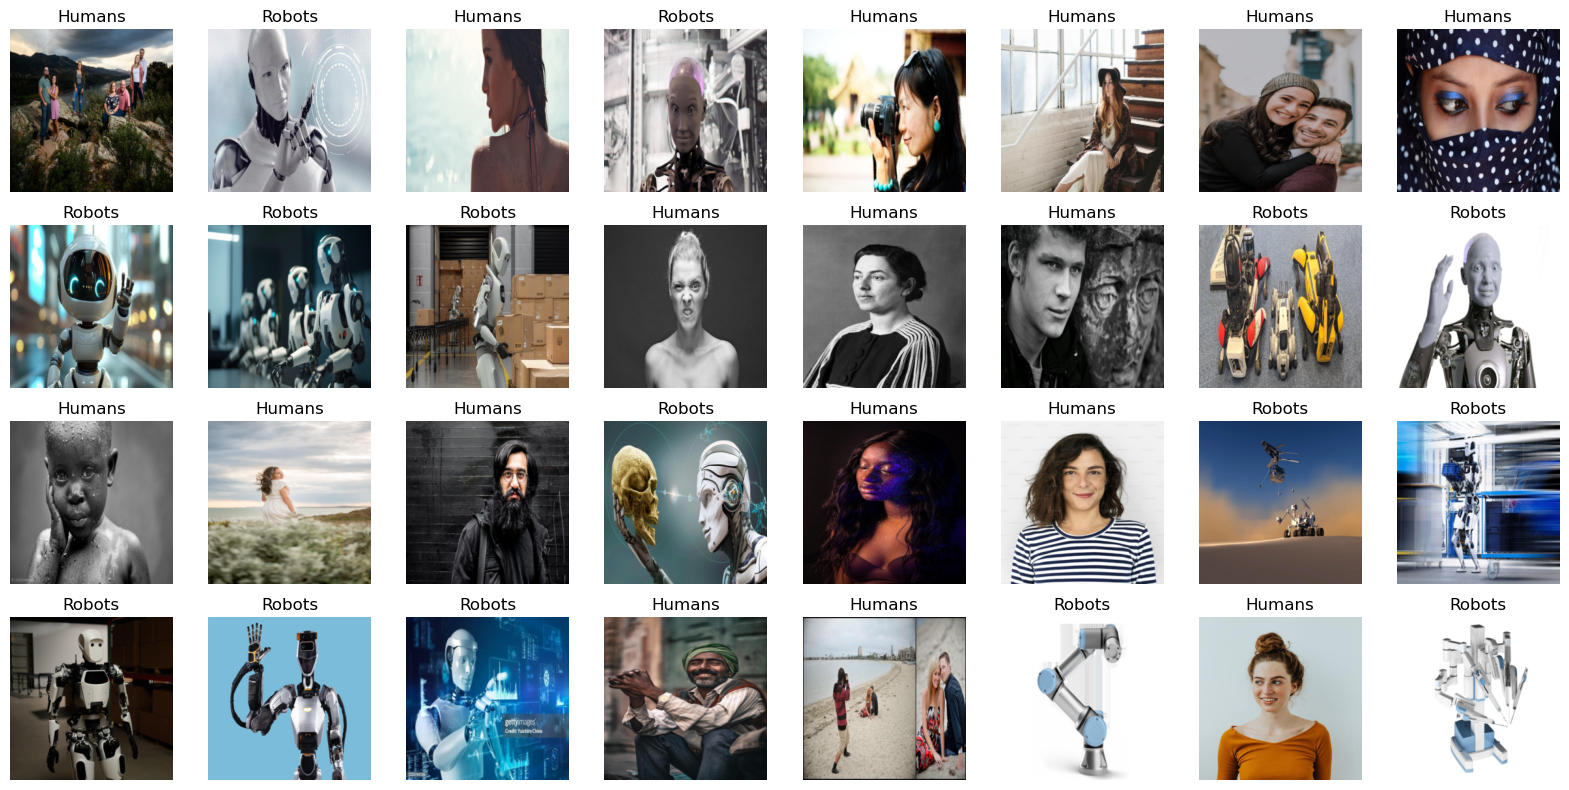

In [8]:
def show_grid(data, titles=None):
    """Imshow for Tensor."""
    data = data.numpy().transpose((0, 2, 3, 1))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    data = std * data + mean 
    data = np.clip(data, 0, 1)
    
    plt.figure(figsize=(8*2, 4*2))
    for i in range(32):
        plt.subplot(4,8,i+1)
        plt.imshow(data[i])
        plt.axis("off")
        if titles is not None:
            plt.title(titles[i])
    plt.tight_layout()
    plt.show()
            
inputs, classes = next(iter(testloader))
titles = [class_names[x] for x in classes]

show_grid(inputs,titles)

In [9]:
TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "CNNs", "CNN_tuned")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [10]:
class CNN_Model(torch.nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv3 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(2, stride=2)
        # Assuming input images are 32x32, after 3 max pooling layers, the size is 4x4
        self.fc1 = torch.nn.Linear(256 * 31 * 31, 128)  # Fully connected layer
        self.fc2 = torch.nn.Linear(128, 2)  # 2 output classes for binary classification
        return
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1, end_dim=-1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [11]:
model = CNN_Model().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train = Wrapper(model = model,device = device, criterion = criterion, optimizer = optimizer,writer=writer)
train.train(10,trainloader,testloader,classes)
writer.close()

Epoch 10 Iter 11: loss 0.08016.: 100%|██████████| 11/11 [00:10<00:00,  1.05it/s]
